In [14]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import pi
from scipy.optimize import minimize
from skimage.io import imread, imsave
from TA2HRR2021 import mirage_analysis, PKG_DATA
from TA2HRR2021.general_tools import choose_cal_file, glob_path, save_object,load_object, get_file_path
from TA2HRR2021.image_analysis import Image_proc
from pathlib import Path
from TA2HRR2021.paths import DATA_FOLDER, CAL_DATA
DATA_PATH = Path(DATA_FOLDER)
git_pkg_data_path = Path(r'/home/cp13938/GitHub/TA2HRR2021/TA2HRR2021/pkg_data')


# Change calibrations here
- Add new the cal_date,cal_files and top_left values for a new calibration
- Change top_left until the ellipse matches the screen

In [15]:

run_name = '20210520/run01'
analysis_folder = Path(r'/data/analysis/GEMINI/2021/App20110001-1/Palmer2021/Calibrations/ProtonSpatial/')
points_df = pd.read_csv(analysis_folder/(run_name.replace('/','_')+'_points.csv'))

points_df.head(20)

,,Area,Mean,Min,Max,X,Y
0,1,0,3.509,3.509,3.509,476.0,409.0
1,2,0,3.382,3.382,3.382,363.5,467.5
2,3,0,3.218,3.218,3.218,226.5,452.5
3,4,0,3.891,3.891,3.891,138.5,379.5
4,5,0,3.582,3.582,3.582,102.5,260.5
5,6,0,3.800,3.800,3.800,121.5,158.5
6,7,0,3.509,3.509,3.509,168.5,80.5
7,8,0,5.345,5.345,5.345,262.5,8.5
8,9,0,3.909,3.909,3.909,455.5,1.5
9,10,0,3.709,3.709,3.709,510.5,39.5


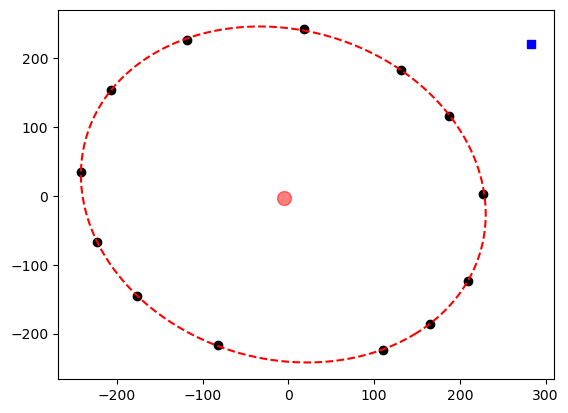

In [16]:
fit_x = points_df['X'].values[:-1]*1.0
fit_y = points_df['Y'].values[:-1]*1.0
cx = np.mean(fit_x)
cy = np.mean(fit_y)
fit_x -=cx
fit_y -=cy
theta = np.linspace(0,2*pi,1000)
# def rotation_matrix(theta):
#     M = [[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]]
#     return M

# def translation_matrix(x_shift,y_shift):
    
def ellipse_fcn(p):
    # p0, p1 a,b
    # p2, p3 cx, cy
    # p4 angle
    # translate
    x = p[0]*np.cos(theta) +p[2]
    y = p[1]*np.sin(theta) +p[3]
    # rotate
    x_dash = x*np.cos(p[4]) - y*np.sin(p[4])
    y_dash = x*np.sin(p[4]) + y*np.cos(p[4])    
    return x_dash,y_dash

def err_fcn(p):
    ex,ey = ellipse_fcn(p)
    r2_err = ((fit_x.reshape(-1,1)-ex.reshape(1,-1))**2+(fit_y.reshape(-1,1)-ey.reshape(1,-1))**2)
    r2_err_min = np.min(r2_err,axis=1)
    return np.sqrt(np.sum(r2_err_min))

res = minimize(err_fcn,[1,1,0,0,0])
res
x = points_df['X'].values[-1]-cx
y = points_df['Y'].values[-1]-cy


plt.plot(fit_x,fit_y,'ko')
xe,ye = ellipse_fcn(res.x)

plt.plot(xe,ye,'r--')
plt.plot(x,y,'bs')
plt.plot(res.x[2],res.x[3],'ro',ms=10,alpha=0.5)

(-38.64, 38.64)

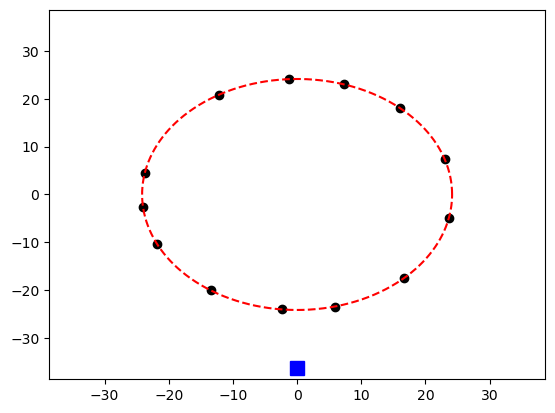

In [17]:
ex,ey = ellipse_fcn(res.x)
r2_err = ((fit_x.reshape(-1,1)-ex.reshape(1,-1))**2+(fit_y.reshape(-1,1)-ey.reshape(1,-1))**2)
theta_min = theta[np.argmin(r2_err,axis=1)]
res.x[-1]

x = points_df['X'].values[-1]-cx-res.x[2]
y = points_df['Y'].values[-1]-cy-res.x[3]

r2_err = ((x.reshape(-1,1)-ex.reshape(1,-1))**2+(y.reshape(-1,1)-ey.reshape(1,-1))**2)
p_angle = theta[np.argmin(r2_err)]

theta_points = theta_min-p_angle-pi/2
r_circ = 48.3/2
x_circ = r_circ*np.cos(theta_points) 
y_circ = r_circ*np.sin(theta_points) 

# plt.plot([x_circ[n] for n in [0,1,6]],[y_circ[n] for n in [0,1,6]],'ko')
plt.plot(x_circ,y_circ,'ko')
plt.plot(r_circ*np.cos(theta),r_circ*np.sin(theta),'r--')

plt.plot(0,-r_circ*1.5,'bs',ms=10,alpha=1.0)
plt.xlim([-r_circ*1.6,r_circ*1.6])
plt.ylim([-r_circ*1.6,r_circ*1.6])

[476.  363.5 226.5 138.5 102.5 121.5 168.5 262.5 455.5 510.5 554.5 572.5
 532.5]


0.0

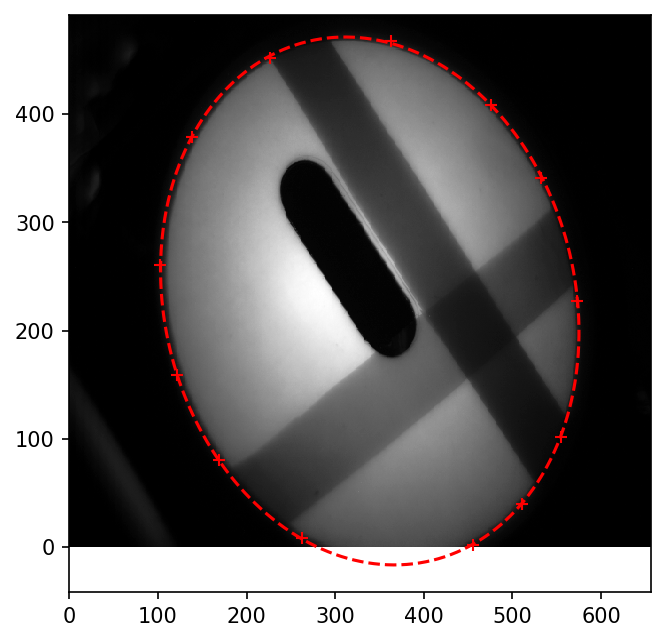

In [18]:
diag = 'ProtonSpatial'
n = 0
cal_date = ['20210520/run01'] # add one on the right for a new calibration
cal_files = ['20210520_run02_avg.tif'] # and hereß
top_left = [[0 ,0]] # here
# reference measurement

test_file = Path(DATA_FOLDER).parent / 'Calibrations' / diag / cal_files[n]
img = imread(test_file)

Ny,Nx = np.shape(img)

imgP_pix = np.array([fit_x+cx,fit_y+cy]).T

imgP_real = np.array([-x_circ,y_circ]).T
# # transform target
Nx_new = 1000
Ny_new = 1000

# # physical range covered by output image
xRange = 60
yRange = 60 
x0 = -30.0
y0 = -30.0

# # physical resolution of output image
dx = xRange/Nx_new
dy = yRange/Ny_new
x_mm = x0 + np.linspace(0,Nx_new,num=Nx_new)*dx
y_mm = y0 + np.linspace(0,Ny_new,num=Ny_new)*dy



# Display image
x_img = np.arange(Nx)
y_img = np.arange(Ny)
XI,YI = np.meshgrid(x_img,y_img)


plt.figure(figsize=(5,5),dpi=150)
plt.pcolormesh(img,shading='auto',cmap='Greys_r')
# plt.imshow(img,vmax=np.percentile(img,95))
plt.plot(imgP_pix[:,0],imgP_pix[:,1],'r+')
# plt.plot(points_df['X'],points_df['Y'],'b+')
print(imgP_pix[:,0])
plt.plot(xe+cx,ye+cy,'r--')

np.min(img)

# Run this box when you are happy with the translation
This will create a new pkl file in the git folder - you will then need to reisntall the package and push to the github to update it for everyone

In [19]:

# calc transform
imgP_trans = (imgP_real-[x0,y0]) / [dx,dy]
H, status = cv2.findHomography(imgP_pix,imgP_trans)

# calculate pixel areas in original image
retval,H_inv = cv2.invert(H)
(X,Y) = np.meshgrid(x_mm,y_mm)
X_raw = cv2.warpPerspective(X, H_inv, (Nx,Ny))
Y_raw = cv2.warpPerspective(Y, H_inv, (Nx,Ny))
imgArea0 = np.abs(np.gradient(X_raw,axis=1)*np.gradient(Y_raw,axis=0))
imgArea0 = np.median(imgArea0[imgArea0>0])


tForm = { 
    'description': f'{diag} image transform',
    'H': H,
    'newImgSize':(Nx_new,Ny_new),
    'x_mm': x_mm,
    'y_mm': y_mm,
    'imgArea0': imgArea0,
    'imgArea1': dx*dy,
    'fC_per_count':1, # temp value
    'imgP_pix': imgP_pix, 'imgP_real':imgP_real
}
save_file_path = git_pkg_data_path / diag / (diag + '_transform_' + cal_date[n].replace('/','_')+'_shot001.pkl')
# save_object(tForm, save_file_path)
# save_file_path


Next cell won't load the new calibration as I have commented out the saving at the end of the cell above to make sure nothing is overwritten.

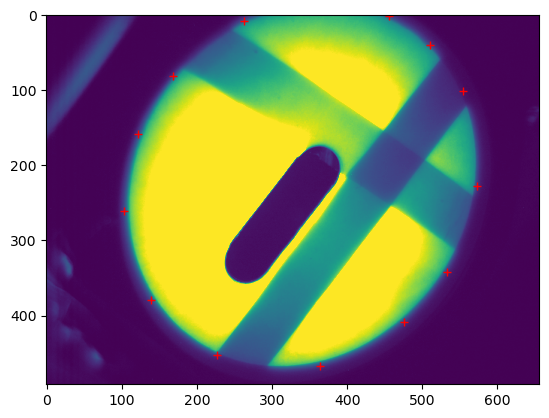

In [20]:


# test_file = Path(DATA_FOLDER).parent / 'calibrations' / diag / '20210511_transform_calib_image.tif'
# test_file = get_file_path(diag,r'20210621/run20',None,1)
# test_file = r'/Users/johnny6/Box/Experiments/Mangles2021/calibrations/espec1/espec1_20210620_run09_avg.tif'
# run_name = '20210727/run01'
# tForm_filepath = choose_cal_file(run_name,1,diag,diag+'_transform',cal_data_path=git_pkg_data_path)
tForm_filepath = save_file_path

pSpatial_proc = Image_proc(tForm_filepath)
img = pSpatial_proc.load_img(test_file)
(Ny,Nx) = np.shape(img)


# calc transformed image
imgCountsPerArea = img/imgArea0
imgCountsPerArea[imgArea0==0] =0
imgCountsPerArea[np.isinf(imgCountsPerArea)] = 0
imgCountsPerArea[np.isnan(imgCountsPerArea)] = 0

im_out = cv2.warpPerspective(imgCountsPerArea, H, (Nx_new,Ny_new))*dx*dy

# Display image
plt.imshow(img,vmax=np.percentile(img,80))
plt.plot(imgP_pix[:,0],imgP_pix[:,1],'r+')
plt.show()

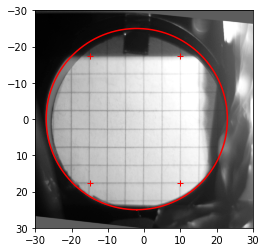

In [74]:


im_out2 = pSpatial_proc.dewarp(img)
plt.imshow(im_out2,extent= (np.min(x_mm), np.max(x_mm), np.max(y_mm), np.min(y_mm)),cmap='Greys_r')
plt.plot(imgP_real[:,0],imgP_real[:,1],'r+')
# plt.clim((0,10))


# ellispse plotting
theta = np.linspace(0,2*np.pi,2000)
a = 25
b = 25
phi = 0*np.pi/180
x_dash = a*np.sin(theta)
y_dash = b*np.cos(theta)
x_e = x_dash*np.cos(phi)-y_dash*np.sin(phi)-2
y_e = x_dash*np.sin(phi)+y_dash*np.cos(phi)
plt.plot(x_e,y_e,'r-')

In [21]:
run_name = '20210522/run01'
tForm_filepath = choose_cal_file(run_name,1,diag,diag+'_transform',cal_data_path=git_pkg_data_path)
tForm_filepath

'/mnt/ceph/home/ms13901/GitHub/TA2HRR2021/TA2HRR2021/pkg_data/ProtonSpatial/ProtonSpatial_transform_20210520_run01_shot001.pkl'